In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [2]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

In [3]:
!wget -O splits.npz "https://raw.githubusercontent.com/Chanevan317/Epilectic-Seizure-Detection-using-ML/main/data/training_data/splits.npz"

--2025-11-30 20:25:37--  https://raw.githubusercontent.com/Chanevan317/Epilectic-Seizure-Detection-using-ML/main/data/training_data/splits.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254056 (248K) [application/octet-stream]
Saving to: ‘splits.npz’

splits.npz          100%[===================>] 248.10K  --.-KB/s    in 0.02s   

2025-11-30 20:25:37 (10.0 MB/s) - ‘splits.npz’ saved [254056/254056]



In [4]:
d = np.load("/content/splits.npz", allow_pickle=True)
X_train = d["X_train"]
X_test = d["X_test"]
y_train = d["y_train"]
y_test = d["y_test"]

In [5]:
!wget -O features_labels.npz "https://raw.githubusercontent.com/Chanevan317/Epilectic-Seizure-Detection-using-ML/main/data/training_data/features_labels.npz"

--2025-11-30 20:25:39--  https://raw.githubusercontent.com/Chanevan317/Epilectic-Seizure-Detection-using-ML/main/data/training_data/features_labels.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139614 (136K) [application/octet-stream]
Saving to: ‘features_labels.npz’

features_labels.npz 100%[===================>] 136.34K  --.-KB/s    in 0.02s   

2025-11-30 20:25:40 (6.38 MB/s) - ‘features_labels.npz’ saved [139614/139614]



In [6]:
d = np.load("/content/features_labels.npz", allow_pickle=True)
X = d["X"]
y = d["y"]

In [10]:
# Start with default parameters
cat_basic = CatBoostClassifier(
    random_state=42,
    verbose=False,  # Set to True if you want to see training progress
    thread_count=-1  # Use all available cores
)

# Train the model
start_time = time.time()
cat_basic.fit(X_train, y_train)
training_time = time.time() - start_time

# Make predictions
y_pred_basic = cat_basic.predict(X_test)

# Evaluate
accuracy_basic = accuracy_score(y_test, y_pred_basic)
print("Basic CatBoost Results:")
print(f"Accuracy: {accuracy_basic:.4f}")
print(f"Training time: {training_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_basic))

Basic CatBoost Results:
Accuracy: 0.9762
Training time: 22.36 seconds

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       425
           1       0.99      0.96      0.97       379
           2       0.96      0.97      0.96       397
           3       0.96      0.97      0.97       399

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



Top 10 Most Important Features:
       feature  importance
7    Feature_7    9.215015
10  Feature_10    8.815719
11  Feature_11    7.610192
15  Feature_15    7.432071
5    Feature_5    6.848254
4    Feature_4    6.502580
6    Feature_6    6.281440
0    Feature_0    6.079506
3    Feature_3    5.810313
8    Feature_8    5.646757


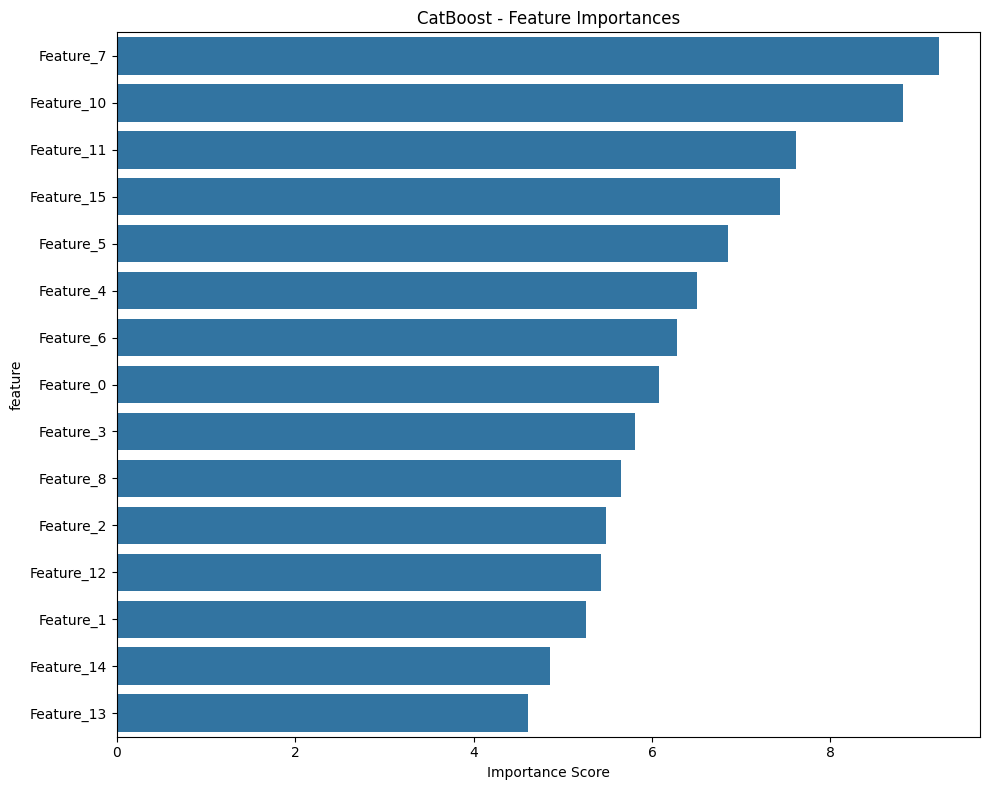

AttributeError: 'CatBoostClassifier' object has no attribute 'plot_feature_importance'

<Figure size 1000x800 with 0 Axes>

In [11]:
# Get feature importances
feature_importances = cat_basic.get_feature_importance()

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'feature': X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X.shape[1])],
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df.head(15), x='importance', y='feature')
plt.title('CatBoost - Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# CatBoost built-in feature importance plot
plt.figure(figsize=(10, 8))
cat_basic.plot_feature_importance()
plt.title('CatBoost - Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
# Define parameter distribution for RandomizedSearch
param_dist = {
    'iterations': [100, 200, 300, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128, 256],
    'random_strength': [0, 0.5, 1, 2]
}

print("Starting Randomized Search for CatBoost...")
start_time = time.time()

# Perform randomized search
random_search = RandomizedSearchCV(
    CatBoostClassifier(random_state=42, verbose=False, thread_count=-1),
    param_distributions=param_dist,
    n_iter=25,  # Number of parameter combinations to try
    cv=3,       # 3-fold CV for speed
    scoring='accuracy',
    n_jobs=-1,  # Note: CatBoost uses thread_count, but we set n_jobs for CV
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print(f"Randomized search completed in {time.time() - start_time:.2f} seconds")

# Best parameters and score
print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

In [ ]:
# Use best parameters from randomized search to inform grid search
print("\nStarting Grid Search for Fine-Tuning...")

# Get best parameters from randomized search
best_params = random_search.best_params_

# Create focused grid around best parameters
param_grid = {
    'iterations': [
        max(50, best_params['iterations'] - 50),
        best_params['iterations'],
        best_params['iterations'] + 50
    ],
    'depth': [
        max(4, best_params['depth'] - 2),
        best_params['depth'],
        min(10, best_params['depth'] + 2)
    ],
    'learning_rate': [
        max(0.01, best_params['learning_rate'] - 0.05),
        best_params['learning_rate'],
        min(0.3, best_params['learning_rate'] + 0.05)
    ],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(
    CatBoostClassifier(random_state=42, verbose=False, thread_count=-1),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters from Grid Search:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

In [ ]:
# Use the best model from grid search
final_cat = grid_search.best_estimator_

# Make final predictions
y_pred_final = final_cat.predict(X_test)
y_pred_proba = final_cat.predict_proba(X_test)  # Probability scores

# Comprehensive evaluation
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\nFinal CatBoost Model Performance:")
print(f"Test Accuracy: {final_accuracy:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_final))

In [ ]:
# CatBoost has its own efficient cross-validation implementation
def catboost_cross_validation(X_train, y_train, params):
    """
    Use CatBoost's built-in cross-validation
    """
    print("Running CatBoost Built-in Cross-Validation...")

    # Create Pool for CatBoost
    train_pool = Pool(X_train, y_train)

    # Run cross-validation
    cv_results = cv(
        pool=train_pool,
        params=params,
        fold_count=5,  # 5-fold CV
        stratified=True,
        partition_random_seed=42,
        verbose=False,
        plot=True  # This will plot the learning curves
    )

    # Get best accuracy
    best_accuracy = cv_results['test-Accuracy-mean'].max()
    best_iteration = cv_results['test-Accuracy-mean'].idxmax()

    print(f"Best CV Accuracy: {best_accuracy:.4f} at iteration {best_iteration}")

    return cv_results, best_accuracy

# Use best parameters for CV
cv_params = grid_search.best_params_.copy()
cv_params.update({
    'loss_function': 'Logloss',
    'random_state': 42,
    'verbose': False
})

# Run CatBoost CV
cv_results, best_cv_accuracy = catboost_cross_validation(X_train, y_train, cv_params)

In [ ]:
# Confusion Matrix and Feature Importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=ax1)
ax1.set_title('CatBoost - Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Feature Importance
feature_importance_df = pd.DataFrame({
    'feature': X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X.shape[1])],
    'importance': final_cat.get_feature_importance()
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance_df.head(10), x='importance', y='feature', ax=ax2)
ax2.set_title('CatBoost - Top 10 Feature Importances')

plt.tight_layout()
plt.show()

# Learning curves (if available)
try:
    plt.figure(figsize=(10, 6))
    final_cat.plot_learning_curve()
    plt.title('CatBoost Learning Curves')
    plt.show()
except:
    print("Learning curve plotting not available in this version")